In [2]:
#This notebook is to run lstm model on CLuster clusters dataset
#loading libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten    
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
# importing Clusters data from zip file
import zipfile
with zipfile.ZipFile("customer_clusters.zip", 'r') as zip_ref:
    # printing all the contents of the zip file 
    zip_ref.printdir()   
    # extracting all the files  
    zip_ref.extractall() 
    print('Done!') 

File Name                                             Modified             Size
timeseries_eight_clusters.csv                  2019-01-10 11:00:34      7695759
timeseries_features_three_clusters.csv         2019-01-10 10:55:06      7695759
timeseries_features_two_clusters.csv           2019-01-10 10:55:22      7695759
timeseries_fifteen_clusters.csv                2019-01-10 10:56:36      7696246
Extracting all the files
Done!


In [4]:
# Reading 8 clusters dataset
df = pd.read_csv("timeseries_eight_clusters.csv")
df.head()

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,

,Unnamed: 0,fv_cost,fv_cost.1,fv_cost.2,fv_cost.3,fv_cost.4,fv_cost.5,fv_cost.6,fv_cost.7,fv_cost.8,...,fv_cost.1453,fv_cost.1454,fv_cost.1455,fv_cost.1456,fv_cost.1457,fv_cost.1458,fv_cost.1459,fv_cost.1460,fv_cost.1461,cluster_lables
0,dates,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,2018-01-01,NaN
1,id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1009141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.47896,-1.2677647,-1.0565412,-0.84528947,-0.6340095,-0.4227012,-0.21136473,0.0,0.211393,5.0
3,1010055,-4.391553,-3.568215,-2.7447665,-1.921208,-1.0975395,-0.27376094,0.5501278,1.3741267,2.1982358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,1018494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [9]:
# lag_feature function is used to get new column in the dataframe with 
#lagged data,number of lags can be given as function parameter 
def lag_feature(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['fv_cost'])
    
    def rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.fv_cost.shift(i).pipe(rename_lag, i))

    df.dropna(inplace=True)
    return df

# Prepare training data function is used to scale the fv_cost values 
# between -1 to 1 and calls lag_feature to create lag columns 
def prepare_training_data(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #cost_vals = scaler.fit_transform(series_data.values.reshape(-1, 1))
    cost_vals = scaler.fit_transform(series_data.reshape(-1, 1))
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

In [13]:
# Reading 100 customers data since previous dataset doesn't have all dates
# data for the customer
cust_1000 = pd.read_csv("data-1000customers.csv")
cust_1000 = cust_1000[['client_debtor_number','dates','fv_cost']]
cust_1000 = cust_1000[cust_1000.fv_cost.notnull()]

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
#create new dataframe with 2 columns
df.rename(columns={'Unnamed: 0':'customer_num'},inplace=True)
cust_cluster_num = pd.DataFrame()
cust_cluster_num['client_debtor_number'] = df['customer_num']
cust_cluster_num['cluster_lables'] = df['cluster_lables']
cust_cluster_num = cust_cluster_num.iloc[2:]
print ("number of customers ",len(cust_cluster_num.client_debtor_number.unique()))
print ("length of cust-1000 dataframe ",len(cust_1000.client_debtor_number.unique()))
print ("clust dist ",cust_cluster_num.cluster_lables.describe())
cust_cluster_num.head()

number of customers  847
length of cust-1000 dataframe  1000
clust dist  count    847.000000
mean       5.540732
std        0.647184
min        1.000000
25%        5.000000
50%        6.000000
75%        6.000000
max        8.000000
Name: cluster_lables, dtype: float64


,client_debtor_number,cluster_lables
2,1009141,5.0
3,1010055,5.0
4,1018494,5.0
5,1020907,6.0
6,1029070,6.0


In [16]:
# Merge 2 datasets on client debtor number column 
merged_cust = pd.merge(cust_cluster_num, cust_1000,on=['client_debtor_number'])
print (merged_cust.head())

# After merging data since the number of customers reduced from 1000 to 847 in clusters dataset 
# we can see decrease in total number of records

290799
  client_debtor_number  cluster_lables       dates  fv_cost
0              7727216             6.0  19/01/2010      0.0
1              7727216             6.0  20/01/2010      0.0
2              7727216             6.0  21/01/2010      0.0
3              7727216             6.0  22/01/2010      0.0
4              7727216             6.0  23/01/2010      0.0


In [17]:
#checking number of customers different to both datasets
data_clust = cust_cluster_num['client_debtor_number'].unique()
data_cust = cust_1000['client_debtor_number'].unique()

print ("number of different customers",len(set(data_clust).difference(set(data_cust))))
# only 347 number of customers match between 2 datasets and 510 are different,adding them
# give 847 customers which are number of customers in 8 clusters dataset

number of different customers 510


In [18]:
# Number of customer for each cluster set
for i in range(1,8):
    #cust_clust_i = cust_cluster_num[cust_cluster_num.cluster_lables == i]
    #clust_i = merged_cust[merged_cust.client_debtor_number == cust_cluster_num.client_debtor_number]
    clust_i = merged_cust[merged_cust.cluster_lables == i]
    print (len(clust_i['client_debtor_number'].unique()))
    

0
0
2
0
131
202
2


In [19]:
# sort data based on dates value
merged_cust['dates'] = pd.to_datetime(merged_cust['dates'],format= '%d/%m/%Y')
merged_cust.sort_values(by='dates',inplace=True)
merged_cust.to_csv("merged_customers.csv")
# create dataframe having cluster labels 5 &6
clust_5 = merged_cust[merged_cust.cluster_lables == 5]
clust_6 = merged_cust[merged_cust.cluster_lables == 6]
#dates is already there no need of having transpose

In [137]:
%%time
# 3 lags for each data point as input to model
lag =  3
# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)
model = Sequential()
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
model.add(Dense(1))
model.add(Dropout(0.2))
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

#run the model on merged clusters data
i=0
train_rmse =[]
test_rmse = []
actual_train_rmse = []
actual_error_scores_test = list()


for cust_id, cust_data in clust_6.groupby('client_debtor_number'):
    print ("customer number ",i)
    i=i+1
    #train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    #test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
    train_x = cust_data[cust_data['dates'].dt.year != 2018]
    test_x = cust_data[cust_data['dates'].dt.year == 2018]
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)  
    model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    # input size should be divisible by batch size for stateful LSTM
    trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
    #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
    #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    #print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
    train_rmse.append(trainScore)
    test_rmse.append(testScore)
    # generate predictions for training
    trainPredict = model.predict(train_x_cust,batch_size=1)
    testPredict = model.predict(test_x_cust,batch_size=1)
    yhat_act_test = scalar_test.inverse_transform(testPredict)
    # report performance
    rmse_test = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
    print(cust_id," Test RMSE: ",rmse_test)
    actual_error_scores_test.append(rmse_test)
    yhat_act_train = scalar_train.inverse_transform(trainScore)
    rmse_train = sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train))
    actual_train_rmse.append(rmse_train)
    # write predictions into csv
    result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
    result_prediction['original_fv_scaled'] = test_y_cust
    result_prediction['prediction_scaled'] = testPredict
    result_prediction['prediction_actual'] = yhat_act_test
    result_prediction['fv_actual'] = test_x.fv_cost[-(len(yhat_act_test)):]
    #result_prediction.to_csv("predictions_1000_customers/predictions_for_client_"+str(cust_id)+".csv")
    model.reset_states()

customer number  0
Epoch 1/10
 - 7s - loss: 0.2033
Epoch 2/10
 - 7s - loss: 0.1891
Epoch 3/10
 - 6s - loss: 0.1824
Epoch 4/10
 - 6s - loss: 0.1831
Epoch 5/10
 - 6s - loss: 0.1884
Epoch 6/10
 - 6s - loss: 0.1745
Epoch 7/10
 - 7s - loss: 0.1826
Epoch 8/10
 - 7s - loss: 0.1913
Epoch 9/10
 - 6s - loss: 0.1953
Epoch 10/10
 - 6s - loss: 0.1752
7727216  Test RMSE:  0.2553535954198108
customer number  1
Epoch 1/10
 - 5s - loss: 0.3160
Epoch 2/10
 - 5s - loss: 0.2072
Epoch 3/10
 - 5s - loss: 0.2131
Epoch 4/10
 - 5s - loss: 0.2341
Epoch 5/10
 - 5s - loss: 0.1866
Epoch 6/10
 - 5s - loss: 0.2086
Epoch 7/10
 - 5s - loss: 0.1907
Epoch 8/10
 - 5s - loss: 0.2042
Epoch 9/10
 - 5s - loss: 0.1926
Epoch 10/10
 - 5s - loss: 0.2288
7808208  Test RMSE:  1.3064545260056744
customer number  2
Epoch 1/10
 - 6s - loss: 0.1771
Epoch 2/10
 - 6s - loss: 0.1772
Epoch 3/10
 - 6s - loss: 0.1911
Epoch 4/10
 - 6s - loss: 0.1590
Epoch 5/10
 - 6s - loss: 0.1798
Epoch 6/10
 - 6s - loss: 0.1631
Epoch 7/10
 - 6s - loss: 0.15

Epoch 7/10
 - 4s - loss: 0.2008
Epoch 8/10
 - 4s - loss: 0.2125
Epoch 9/10
 - 4s - loss: 0.2112
Epoch 10/10
 - 4s - loss: 0.2021
7925425  Test RMSE:  0.3020156717685844
customer number  22
Epoch 1/10
 - 5s - loss: 0.0827
Epoch 2/10
 - 5s - loss: 0.0830
Epoch 3/10
 - 5s - loss: 0.0821
Epoch 4/10
 - 5s - loss: 0.0683
Epoch 5/10
 - 5s - loss: 0.0745
Epoch 6/10
 - 5s - loss: 0.0799
Epoch 7/10
 - 5s - loss: 0.0716
Epoch 8/10
 - 5s - loss: 0.0794
Epoch 9/10
 - 5s - loss: 0.0787
Epoch 10/10
 - 5s - loss: 0.0813
7932979  Test RMSE:  0.19534159599556503
customer number  23
Epoch 1/10
 - 5s - loss: 0.1638
Epoch 2/10
 - 5s - loss: 0.1611
Epoch 3/10
 - 5s - loss: 0.1526
Epoch 4/10
 - 5s - loss: 0.1506
Epoch 5/10
 - 5s - loss: 0.1596
Epoch 6/10
 - 5s - loss: 0.1680
Epoch 7/10
 - 5s - loss: 0.1523
Epoch 8/10
 - 5s - loss: 0.1485
Epoch 9/10
 - 5s - loss: 0.1337
Epoch 10/10
 - 5s - loss: 0.1623
7937008  Test RMSE:  5.036849094869853
customer number  24
Epoch 1/10
 - 5s - loss: 0.1664
Epoch 2/10
 - 5s 

 - 5s - loss: 0.1415
Epoch 2/10
 - 5s - loss: 0.1195
Epoch 3/10
 - 5s - loss: 0.1296
Epoch 4/10
 - 5s - loss: 0.1307
Epoch 5/10
 - 5s - loss: 0.1573
Epoch 6/10
 - 5s - loss: 0.1367
Epoch 7/10
 - 5s - loss: 0.1529
Epoch 8/10
 - 5s - loss: 0.1655
Epoch 9/10
 - 5s - loss: 0.1380
Epoch 10/10
 - 5s - loss: 0.1491
7984561  Test RMSE:  3.624243840216065
customer number  44
Epoch 1/10
 - 4s - loss: 0.1851
Epoch 2/10
 - 4s - loss: 0.1672
Epoch 3/10
 - 4s - loss: 0.1590
Epoch 4/10
 - 4s - loss: 0.1634
Epoch 5/10
 - 4s - loss: 0.1636
Epoch 6/10
 - 4s - loss: 0.1727
Epoch 7/10
 - 4s - loss: 0.1636
Epoch 8/10
 - 4s - loss: 0.1675
Epoch 9/10
 - 4s - loss: 0.1562
Epoch 10/10
 - 4s - loss: 0.1671
7994532  Test RMSE:  0.46927455830829085
customer number  45
Epoch 1/10
 - 4s - loss: 0.0795
Epoch 2/10
 - 4s - loss: 0.0793
Epoch 3/10
 - 4s - loss: 0.0758
Epoch 4/10
 - 4s - loss: 0.0861
Epoch 5/10
 - 4s - loss: 0.0705
Epoch 6/10
 - 4s - loss: 0.0772
Epoch 7/10
 - 4s - loss: 0.0738
Epoch 8/10
 - 4s - loss: 

 - 4s - loss: 0.0264
Epoch 8/10
 - 4s - loss: 0.0245
Epoch 9/10
 - 4s - loss: 0.0236
Epoch 10/10
 - 4s - loss: 0.0228
8083258  Test RMSE:  0.2232344627000139
customer number  65
Epoch 1/10
 - 4s - loss: 0.1749
Epoch 2/10
 - 4s - loss: 0.1659
Epoch 3/10
 - 4s - loss: 0.1592
Epoch 4/10
 - 4s - loss: 0.1413
Epoch 5/10
 - 4s - loss: 0.1598
Epoch 6/10
 - 4s - loss: 0.1586
Epoch 7/10
 - 4s - loss: 0.1646
Epoch 8/10
 - 4s - loss: 0.1461
Epoch 9/10
 - 4s - loss: 0.1688
Epoch 10/10
 - 5s - loss: 0.1405
8087326  Test RMSE:  1.0755294067811367
customer number  66
Epoch 1/10
 - 5s - loss: 0.1990
Epoch 2/10
 - 4s - loss: 0.1956
Epoch 3/10
 - 4s - loss: 0.1866
Epoch 4/10
 - 4s - loss: 0.1986
Epoch 5/10
 - 4s - loss: 0.1889
Epoch 6/10
 - 4s - loss: 0.1985
Epoch 7/10
 - 4s - loss: 0.2044
Epoch 8/10
 - 4s - loss: 0.2171
Epoch 9/10
 - 4s - loss: 0.2068
Epoch 10/10
 - 4s - loss: 0.2082
8087946  Test RMSE:  0.17307579517364502
customer number  67
Epoch 1/10
 - 4s - loss: 0.0744
Epoch 2/10
 - 4s - loss: 0.

 - 4s - loss: 0.1555
Epoch 2/10
 - 4s - loss: 0.1616
Epoch 3/10
 - 4s - loss: 0.1587
Epoch 4/10
 - 4s - loss: 0.1700
Epoch 5/10
 - 4s - loss: 0.1480
Epoch 6/10
 - 4s - loss: 0.1464
Epoch 7/10
 - 4s - loss: 0.1540
Epoch 8/10
 - 4s - loss: 0.1539
Epoch 9/10
 - 4s - loss: 0.1551
Epoch 10/10
 - 4s - loss: 0.1553
8161178  Test RMSE:  0.2069020328384197
customer number  87
Epoch 1/10
 - 5s - loss: 0.0757
Epoch 2/10
 - 5s - loss: 0.0720
Epoch 3/10
 - 5s - loss: 0.0797
Epoch 4/10
 - 5s - loss: 0.0830
Epoch 5/10
 - 5s - loss: 0.0693
Epoch 6/10
 - 5s - loss: 0.0727
Epoch 7/10
 - 5s - loss: 0.0721
Epoch 8/10
 - 5s - loss: 0.0832
Epoch 9/10
 - 5s - loss: 0.0783
Epoch 10/10
 - 5s - loss: 0.0828
8165580  Test RMSE:  0.21315399115107647
customer number  88
Epoch 1/10
 - 4s - loss: 0.1666
Epoch 2/10
 - 4s - loss: 0.1815
Epoch 3/10
 - 4s - loss: 0.1783
Epoch 4/10
 - 4s - loss: 0.1886
Epoch 5/10
 - 4s - loss: 0.1868
Epoch 6/10
 - 4s - loss: 0.1698
Epoch 7/10
 - 4s - loss: 0.1839
Epoch 8/10
 - 4s - loss:

 - 5s - loss: 0.0306
Epoch 8/10
 - 5s - loss: 0.0371
Epoch 9/10
 - 5s - loss: 0.0392
Epoch 10/10
 - 5s - loss: 0.0385
8276005  Test RMSE:  1.2673443782275384
customer number  108
Epoch 1/10
 - 5s - loss: 0.1787
Epoch 2/10
 - 5s - loss: 0.1566
Epoch 3/10
 - 5s - loss: 0.1752
Epoch 4/10
 - 5s - loss: 0.1827
Epoch 5/10
 - 5s - loss: 0.1794
Epoch 6/10
 - 5s - loss: 0.1969
Epoch 7/10
 - 4s - loss: 0.1644
Epoch 8/10
 - 4s - loss: 0.1747
Epoch 9/10
 - 4s - loss: 0.1624
Epoch 10/10
 - 4s - loss: 0.1797
8276129  Test RMSE:  0.19865981915430436
customer number  109
Epoch 1/10
 - 4s - loss: 0.1655
Epoch 2/10
 - 4s - loss: 0.1536
Epoch 3/10
 - 5s - loss: 0.1679
Epoch 4/10
 - 6s - loss: 0.1823
Epoch 5/10
 - 5s - loss: 0.1687
Epoch 6/10
 - 5s - loss: 0.1690
Epoch 7/10
 - 4s - loss: 0.1414
Epoch 8/10
 - 4s - loss: 0.1969
Epoch 9/10
 - 4s - loss: 0.1726
Epoch 10/10
 - 4s - loss: 0.1572
8304793  Test RMSE:  0.19886632214381106
customer number  110
Epoch 1/10
 - 4s - loss: 0.2074
Epoch 2/10
 - 4s - loss

 - 4s - loss: 0.1594
Epoch 2/10
 - 5s - loss: 0.1735
Epoch 3/10
 - 4s - loss: 0.1428
Epoch 4/10
 - 5s - loss: 0.1487
Epoch 5/10
 - 4s - loss: 0.1765
Epoch 6/10
 - 5s - loss: 0.1586
Epoch 7/10
 - 4s - loss: 0.1639
Epoch 8/10
 - 5s - loss: 0.1754
Epoch 9/10
 - 5s - loss: 0.1575
Epoch 10/10
 - 5s - loss: 0.1621
8453225  Test RMSE:  0.210737896096726
customer number  130
Epoch 1/10
 - 6s - loss: 0.1291
Epoch 2/10
 - 6s - loss: 0.1412
Epoch 3/10
 - 6s - loss: 0.1176
Epoch 4/10
 - 5s - loss: 0.1303
Epoch 5/10
 - 5s - loss: 0.1355
Epoch 6/10
 - 5s - loss: 0.1369
Epoch 7/10
 - 6s - loss: 0.1298
Epoch 8/10
 - 5s - loss: 0.1653
Epoch 9/10
 - 5s - loss: 0.1219
Epoch 10/10
 - 5s - loss: 0.1290
8463239  Test RMSE:  0.2194778255054039
customer number  131
Epoch 1/10
 - 5s - loss: 0.1734
Epoch 2/10
 - 5s - loss: 0.1653
Epoch 3/10
 - 5s - loss: 0.1749
Epoch 4/10
 - 5s - loss: 0.1923
Epoch 5/10
 - 5s - loss: 0.1699
Epoch 6/10
 - 6s - loss: 0.1605
Epoch 7/10
 - 6s - loss: 0.1689
Epoch 8/10
 - 6s - loss:

Epoch 7/10
 - 4s - loss: 0.1181
Epoch 8/10
 - 4s - loss: 0.1270
Epoch 9/10
 - 4s - loss: 0.0978
Epoch 10/10
 - 4s - loss: 0.1132
8561214  Test RMSE:  4.530800638347249
customer number  151
Epoch 1/10
 - 5s - loss: 0.1801
Epoch 2/10
 - 5s - loss: 0.1669
Epoch 3/10
 - 6s - loss: 0.1560
Epoch 4/10
 - 6s - loss: 0.1487
Epoch 5/10
 - 6s - loss: 0.1589
Epoch 6/10
 - 6s - loss: 0.1611
Epoch 7/10
 - 5s - loss: 0.1692
Epoch 8/10
 - 5s - loss: 0.1718
Epoch 9/10
 - 5s - loss: 0.1955
Epoch 10/10
 - 5s - loss: 0.1767
8562016  Test RMSE:  0.19964171554315566
customer number  152
Epoch 1/10
 - 5s - loss: 0.1287
Epoch 2/10
 - 5s - loss: 0.1518
Epoch 3/10
 - 5s - loss: 0.1358
Epoch 4/10
 - 4s - loss: 0.1196
Epoch 5/10
 - 4s - loss: 0.1227
Epoch 6/10
 - 4s - loss: 0.1274
Epoch 7/10
 - 4s - loss: 0.1234
Epoch 8/10
 - 4s - loss: 0.1466
Epoch 9/10
 - 4s - loss: 0.1563
Epoch 10/10
 - 4s - loss: 0.1339
8563926  Test RMSE:  0.2746373731207339
customer number  153
Epoch 1/10
 - 5s - loss: 0.1805
Epoch 2/10
 - 

 - 4s - loss: 0.1381
Epoch 2/10
 - 4s - loss: 0.1495
Epoch 3/10
 - 4s - loss: 0.1672
Epoch 4/10
 - 4s - loss: 0.1378
Epoch 5/10
 - 4s - loss: 0.1409
Epoch 6/10
 - 4s - loss: 0.1471
Epoch 7/10
 - 4s - loss: 0.1526
Epoch 8/10
 - 4s - loss: 0.1259
Epoch 9/10
 - 4s - loss: 0.1444
Epoch 10/10
 - 5s - loss: 0.1396
9337687  Test RMSE:  0.21339788443110533
customer number  173
Epoch 1/10
 - 5s - loss: 0.0493
Epoch 2/10
 - 5s - loss: 0.0534
Epoch 3/10
 - 4s - loss: 0.0465
Epoch 4/10
 - 4s - loss: 0.0593
Epoch 5/10
 - 4s - loss: 0.0552
Epoch 6/10
 - 4s - loss: 0.0512
Epoch 7/10
 - 4s - loss: 0.0524
Epoch 8/10
 - 4s - loss: 0.0543
Epoch 9/10
 - 4s - loss: 0.0522
Epoch 10/10
 - 4s - loss: 0.0467
9337881  Test RMSE:  0.23557936574830868
customer number  174
Epoch 1/10
 - 6s - loss: 0.1803
Epoch 2/10
 - 6s - loss: 0.1659
Epoch 3/10
 - 6s - loss: 0.1614
Epoch 4/10
 - 6s - loss: 0.1672
Epoch 5/10
 - 6s - loss: 0.1589
Epoch 6/10
 - 5s - loss: 0.1492
Epoch 7/10
 - 5s - loss: 0.1617
Epoch 8/10
 - 5s - lo

Epoch 7/10
 - 6s - loss: 0.1492
Epoch 8/10
 - 5s - loss: 0.1560
Epoch 9/10
 - 5s - loss: 0.1536
Epoch 10/10
 - 5s - loss: 0.1548
9783520  Test RMSE:  93.39023313601135
customer number  194
Epoch 1/10
 - 5s - loss: 0.1351
Epoch 2/10
 - 5s - loss: 0.1173
Epoch 3/10
 - 5s - loss: 0.1231
Epoch 4/10
 - 5s - loss: 0.1326
Epoch 5/10
 - 5s - loss: 0.1191
Epoch 6/10
 - 5s - loss: 0.1245
Epoch 7/10
 - 5s - loss: 0.1211
Epoch 8/10
 - 6s - loss: 0.1065
Epoch 9/10
 - 6s - loss: 0.1284
Epoch 10/10
 - 5s - loss: 0.1326
9857915  Test RMSE:  0.22017020313956778
customer number  195
Epoch 1/10
 - 5s - loss: 0.1714
Epoch 2/10
 - 5s - loss: 0.1799
Epoch 3/10
 - 5s - loss: 0.1656
Epoch 4/10
 - 5s - loss: 0.1583
Epoch 5/10
 - 6s - loss: 0.1859
Epoch 6/10
 - 6s - loss: 0.1780
Epoch 7/10
 - 5s - loss: 0.1619
Epoch 8/10
 - 5s - loss: 0.1749
Epoch 9/10
 - 5s - loss: 0.1795
Epoch 10/10
 - 6s - loss: 0.1789
9911561  Test RMSE:  18.201288606193657
customer number  196
Epoch 1/10
 - 4s - loss: 0.0909
Epoch 2/10
 - 

In [20]:
#since the customers doesn't match 
# working on customers Clusters datasets
with zipfile.ZipFile("clusters_timeseries_1000_customer_no_collection_comments.zip", 'r') as zip_ref:
    # printing all the contents of the zip file 
    zip_ref.printdir() 
  
    # extracting all the files 
    print('Extracting all the files') 
    zip_ref.extractall() 
    print('Done!') 

File Name                                             Modified             Size
part-00000-581ed144-c0f2-45b7-b743-a35fb688f431-c000.csv 2019-01-19 10:38:12     63898832
Extracting all the files
Done!


In [21]:
new_cust_data = pd.read_csv("part-00000-581ed144-c0f2-45b7-b743-a35fb688f431-c000.csv")
new_cust_data = new_cust_data[['client_debtor_number','dates','fv_cost']]
new_cust_data.head()


,client_debtor_number,dates,fv_cost
0,7347391,12/03/2010,0.0
1,7347391,13/03/2010,0.0
2,7347391,14/03/2010,0.0
3,7347391,15/03/2010,0.0
4,7347391,16/03/2010,0.0


In [22]:
merged_data = pd.merge(cust_cluster_num, new_cust_data,on=['client_debtor_number'])
print ("number of different customers",
       len(set(cust_cluster_num['client_debtor_number'].unique()).difference(
           set(new_cust_data['client_debtor_number'].unique()))))
#gives same number of different customers

number of different customers 510


In [23]:
#try with second dataset
with zipfile.ZipFile("clusters_timeseries_1000_customers_original_format.zip", 'r') as zip_ref:
    # printing all the contents of the zip file 
    zip_ref.printdir() 
  
    # extracting all the files 
    print('Extracting all the files') 
    zip_ref.extractall() 
    print('Done!') 

File Name                                             Modified             Size
part-00000-df6d76cc-e9b8-44d0-a160-d097564c22a5-c000.csv 2019-01-19 10:35:02     81297783
Extracting all the files
Done!


In [24]:
new_cust_update = pd.read_csv("part-00000-df6d76cc-e9b8-44d0-a160-d097564c22a5-c000.csv")
new_cust_update = new_cust_update[['client_debtor_number','dates','fv_cost']]
new_cust_update.head()

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,client_debtor_number,dates,fv_cost
0,7347391,12/03/2010,0.0
1,7347391,13/03/2010,0.0
2,7347391,14/03/2010,0.0
3,7347391,15/03/2010,0.0
4,7347391,16/03/2010,0.0


In [25]:
print ("number of different customers",
       len(set(cust_cluster_num['client_debtor_number'].unique()).difference(
           set(new_cust_update['client_debtor_number'].unique()))))

number of different customers 510


In [52]:
# sort the dates in ascending
merged_data['dates'] = pd.to_datetime(merged_data['dates'],format= '%d/%m/%Y')
merged_data.sort_values(by='dates',inplace=True)
merged_data.to_csv("merged_customers.csv")
#run on merged data set for clusters
clust_5_data = merged_data[merged_data.cluster_lables == 5]
clust_6_data = merged_data[merged_data.cluster_lables == 6]
clust_5_data.reset_index(drop=True,inplace=True)
clust_6_data.reset_index(drop=True,inplace=True)

In [41]:
def difference(dataset):
    interval=1
    diff = list()
    for i in range(interval, len(dataset)):
        print ("iteration ",i)
        value = (dataset.iloc[i] - dataset.iloc[i - interval])/(1+abs(dataset.iloc[i - interval]))
        diff.append(value)
    return diff

In [28]:
%%time
# 3 lags for each data point as input to model
lag =  3
# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)
model = Sequential()
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
model.add(Dense(1))
model.add(Dropout(0.2))
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

#run the model on merged clusters data
i=0
train_rmse =[]
test_rmse = []
actual_train_rmse = []
actual_error_scores_test = list()


for cust_id, cust_data in clust_6.groupby('client_debtor_number'):
    print ("customer number ",i)
    i=i+1
    #train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    #test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
    train_x = cust_data[cust_data['dates'].dt.year != 2018]
    test_x = cust_data[cust_data['dates'].dt.year == 2018]
    #already date sorted no need to sort again
    #differencing data to remove trend
    diff_train = np.array(difference(train_x['fv_cost']))
    diff_test = np.array(difference(test_x['fv_cost']))
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(diff_train, 3)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(diff_test, 3)  
    model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    # input size should be divisible by batch size for stateful LSTM
    trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
    #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
    #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    #print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
    train_rmse.append(trainScore)
    test_rmse.append(testScore)
    # generate predictions for training
    trainPredict = model.predict(train_x_cust,batch_size=1)
    testPredict = model.predict(test_x_cust,batch_size=1)
    yhat_act_test = [scalar_test.inverse_transform(testPredict)[i-lag]+diff_test[i]
                 for i in range(lag,len(diff_test))]
    # report performance
    rmse_test = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
    print(cust_id," Test RMSE: ",rmse_test)
    actual_error_scores_test.append(rmse_test)
    yhat_act_train = [scalar_train.inverse_transform(trainPredict)[i-lag]+diff_train[i]
                  for i in range(lag,len(diff_train))]
    rmse_train = sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train))
    actual_train_rmse.append(rmse_train)
    # write predictions into csv
    result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
    result_prediction['original_fv_scaled'] = test_y_cust
    result_prediction['prediction_scaled'] = testPredict
    result_prediction['prediction_actual'] = yhat_act_test
    result_prediction['fv_actual'] = test_x.fv_cost[-(len(yhat_act_test)):]
    #result_prediction.to_csv("predictions_1000_customers/predictions_for_client_"+str(cust_id)+".csv")
    model.reset_states()

customer number  0


KeyError: 150

In [54]:
%%time
#experiment on cluster
lag =  3
# model parameters
num_neurons = 50 #24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)
dropout_rate =0.2
# instantiate a sequential model
model = Sequential()
model.add(Conv1D(filters=num_neurons,batch_size=1, kernel_size=3, 
                 strides=3, 
                 padding="same",activation='linear',dilation_rate=1, 
                 input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
#model.add(Dense(16,activation='linear'))
#model.add(Dense(18,activation='linear'))
model.add(Dense(1,activation='linear'))
from keras import optimizers
adam = optimizers.Adam(lr=0.01, decay=0.01)
model.compile(loss='mean_squared_error', optimizer=adam)

#run the model on merged clusters data
i=0
train_rmse =[]
test_rmse = []
actual_train_rmse = []
actual_error_scores_test = list()


for cust_id, cust_data in clust_5_data.groupby('client_debtor_number'):
    print ("customer number ",i)
    i=i+1
    #train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
    #test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
    train_x = cust_data[cust_data['dates'].dt.year != 2018]
    test_x = cust_data[cust_data['dates'].dt.year == 2018]
    #diff_train = np.array(difference(train_x['fv_cost']))
    #diff_test = np.array(difference(test_x['fv_cost']))
    train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
    test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)  
    model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    # input size should be divisible by batch size for stateful LSTM
    trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
    #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
    #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    #print('unscaled test score %f MSE' %(scaler.inverse_transform(testScore)))
    train_rmse.append(trainScore)
    test_rmse.append(testScore)
    # generate predictions for training
    trainPredict = model.predict(train_x_cust,batch_size=1)
    testPredict = model.predict(test_x_cust,batch_size=1)
    #yhat_act_test = [scalar_test.inverse_transform(testPredict)[i-lag]+diff_test[i]
    #                for i in range(lag,len(diff_test))]
    yhat_act_test = scalar_test.inverse_transform(testPredict)
    # report performance
    rmse_test = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
    print(cust_id," Test RMSE: ",rmse_test)
    actual_error_scores_test.append(rmse_test)
    #yhat_act_train = [scalar_train.inverse_transform(trainPredict)[i-lag]+diff_train[i]
    #              for i in range(lag,len(diff_train))]
    yhat_act_train = scalar_train.inverse_transform(trainPredict)
    rmse_train = sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train))
    actual_train_rmse.append(rmse_train)
    # write predictions into csv
    result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
    result_prediction['original_fv_scaled'] = test_y_cust
    result_prediction['prediction_scaled'] = testPredict
    result_prediction['prediction_actual'] = yhat_act_test
    result_prediction['fv_actual'] = test_x.fv_cost[-(len(yhat_act_test)):]
    #result_prediction.to_csv("predictions_1000_customers/predictions_for_client_"+str(cust_id)+".csv")
    model.reset_states()

customer number  0


/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Epoch 1/10
 - 17s - loss: 0.0395
Epoch 2/10
 - 14s - loss: 0.0491
Epoch 3/10
 - 14s - loss: 0.0794
Epoch 4/10
 - 14s - loss: 0.0554
Epoch 5/10
 - 14s - loss: 0.0192
Epoch 6/10
 - 15s - loss: 0.0134
Epoch 7/10
 - 15s - loss: 0.0124
Epoch 8/10
 - 14s - loss: 0.0119
Epoch 9/10
 - 14s - loss: 0.0123
Epoch 10/10
 - 14s - loss: 0.0108
7755945  Test RMSE:  0.038300842858525655
customer number  1
Epoch 1/10
 - 12s - loss: 0.0169
Epoch 2/10
 - 12s - loss: 0.0114
Epoch 3/10
 - 12s - loss: 0.0115
Epoch 4/10
 - 13s - loss: 0.0106
Epoch 5/10
 - 13s - loss: 0.0098
Epoch 6/10
 - 13s - loss: 0.0089
Epoch 7/10
 - 13s - loss: 0.0095
Epoch 8/10
 - 12s - loss: 0.0078
Epoch 9/10
 - 12s - loss: 0.0087
Epoch 10/10
 - 12s - loss: 0.0089
7762445  Test RMSE:  0.12566407790468684
customer number  2
Epoch 1/10
 - 12s - loss: 0.0173
Epoch 2/10
 - 12s - loss: 0.0111
Epoch 3/10
 - 12s - loss: 0.0095
Epoch 4/10
 - 12s - loss: 0.0090
Epoch 5/10
 - 12s - loss: 0.0093
Epoch 6/10
 - 12s - loss: 0.0090
Epoch 7/10
 - 12s -

 - 11s - loss: 0.0071
Epoch 2/10
 - 11s - loss: 0.0070
Epoch 3/10
 - 11s - loss: 0.0058
Epoch 4/10
 - 11s - loss: 0.0052
Epoch 5/10
 - 12s - loss: 0.0055
Epoch 6/10
 - 11s - loss: 0.0051
Epoch 7/10
 - 11s - loss: 0.0047
Epoch 8/10
 - 12s - loss: 0.0046
Epoch 9/10
 - 11s - loss: 0.0047
Epoch 10/10
 - 11s - loss: 0.0044
7985789  Test RMSE:  0.1436366587391166
customer number  22
Epoch 1/10
 - 11s - loss: 0.0253
Epoch 2/10
 - 11s - loss: 0.0087
Epoch 3/10
 - 11s - loss: 0.0081
Epoch 4/10
 - 11s - loss: 0.0081
Epoch 5/10
 - 11s - loss: 0.0077
Epoch 6/10
 - 11s - loss: 0.0087
Epoch 7/10
 - 11s - loss: 0.0083
Epoch 8/10
 - 11s - loss: 0.0081
Epoch 9/10
 - 11s - loss: 0.0081
Epoch 10/10
 - 11s - loss: 0.0078
7990375  Test RMSE:  0.13689100942765875
customer number  23
Epoch 1/10
 - 13s - loss: 0.0417
Epoch 2/10
 - 13s - loss: 0.0133
Epoch 3/10
 - 13s - loss: 0.0124
Epoch 4/10
 - 13s - loss: 0.0121
Epoch 5/10
 - 13s - loss: 0.0116
Epoch 6/10
 - 13s - loss: 0.0122
Epoch 7/10
 - 13s - loss: 0.01

 - 11s - loss: 0.0146
Epoch 2/10
 - 11s - loss: 0.0087
Epoch 3/10
 - 11s - loss: 0.0086
Epoch 4/10
 - 11s - loss: 0.0077
Epoch 5/10
 - 11s - loss: 0.0081
Epoch 6/10
 - 11s - loss: 0.0077
Epoch 7/10
 - 11s - loss: 0.0074
Epoch 8/10
 - 11s - loss: 0.0076
Epoch 9/10
 - 11s - loss: 0.0079
Epoch 10/10
 - 11s - loss: 0.0077
8124507  Test RMSE:  0.13359748545051234
customer number  43
Epoch 1/10
 - 11s - loss: 0.0185
Epoch 2/10
 - 11s - loss: 0.0040
Epoch 3/10
 - 11s - loss: 6.9606e-04
Epoch 4/10
 - 11s - loss: 3.0128e-04
Epoch 5/10
 - 11s - loss: 2.5311e-04
Epoch 6/10
 - 11s - loss: 2.6102e-04
Epoch 7/10
 - 11s - loss: 2.0260e-04
Epoch 8/10
 - 11s - loss: 1.7898e-04
Epoch 9/10
 - 11s - loss: 2.2498e-04
Epoch 10/10
 - 11s - loss: 1.8861e-04
8124701  Test RMSE:  0.002080630565165718
customer number  44
Epoch 1/10
 - 11s - loss: 0.0276
Epoch 2/10
 - 11s - loss: 0.0204
Epoch 3/10
 - 11s - loss: 0.0188
Epoch 4/10
 - 11s - loss: 0.0187
Epoch 5/10
 - 11s - loss: 0.0183
Epoch 6/10
 - 11s - loss: 0.0

 - 13s - loss: 0.0290
Epoch 2/10
 - 13s - loss: 0.0292
Epoch 3/10
 - 13s - loss: 0.0277
Epoch 4/10
 - 13s - loss: 0.0273
Epoch 5/10
 - 13s - loss: 0.0274
Epoch 6/10
 - 13s - loss: 0.0265
Epoch 7/10
 - 13s - loss: 0.0277
Epoch 8/10
 - 13s - loss: 0.0273
Epoch 9/10
 - 13s - loss: 0.0272
Epoch 10/10
 - 13s - loss: 0.0261
8227322  Test RMSE:  0.41034553160742493
customer number  64
Epoch 1/10
 - 11s - loss: 0.0097
Epoch 2/10
 - 11s - loss: 0.0077
Epoch 3/10
 - 11s - loss: 0.0079
Epoch 4/10
 - 11s - loss: 0.0076
Epoch 5/10
 - 11s - loss: 0.0072
Epoch 6/10
 - 11s - loss: 0.0074
Epoch 7/10
 - 11s - loss: 0.0074
Epoch 8/10
 - 11s - loss: 0.0076
Epoch 9/10
 - 11s - loss: 0.0075
Epoch 10/10
 - 11s - loss: 0.0077
8240345  Test RMSE:  0.11910747130578163
customer number  65
Epoch 1/10
 - 11s - loss: 0.0208
Epoch 2/10
 - 11s - loss: 0.0076
Epoch 3/10
 - 11s - loss: 0.0064
Epoch 4/10
 - 11s - loss: 0.0060
Epoch 5/10
 - 11s - loss: 0.0057
Epoch 6/10
 - 11s - loss: 0.0057
Epoch 7/10
 - 11s - loss: 0.0

 - 14s - loss: 0.0168
Epoch 2/10
 - 16s - loss: 0.0146
Epoch 3/10
 - 14s - loss: 0.0135
Epoch 4/10
 - 14s - loss: 0.0126
Epoch 5/10
 - 15s - loss: 0.0131
Epoch 6/10
 - 14s - loss: 0.0133
Epoch 7/10
 - 14s - loss: 0.0129
Epoch 8/10
 - 14s - loss: 0.0128
Epoch 9/10
 - 14s - loss: 0.0128
Epoch 10/10
 - 14s - loss: 0.0126
8433690  Test RMSE:  1.1943388172859262
customer number  85
Epoch 1/10
 - 12s - loss: 0.0113
Epoch 2/10
 - 12s - loss: 0.0091
Epoch 3/10
 - 12s - loss: 0.0081
Epoch 4/10
 - 12s - loss: 0.0082
Epoch 5/10
 - 12s - loss: 0.0082
Epoch 6/10
 - 12s - loss: 0.0079
Epoch 7/10
 - 12s - loss: 0.0079
Epoch 8/10
 - 12s - loss: 0.0080
Epoch 9/10
 - 12s - loss: 0.0079
Epoch 10/10
 - 12s - loss: 0.0078
8434948  Test RMSE:  0.08239228754586306
customer number  86
Epoch 1/10
 - 14s - loss: 0.0065
Epoch 2/10
 - 14s - loss: 0.0064
Epoch 3/10
 - 14s - loss: 0.0068
Epoch 4/10
 - 14s - loss: 0.0070
Epoch 5/10
 - 14s - loss: 0.0063
Epoch 6/10
 - 14s - loss: 0.0070
Epoch 7/10
 - 14s - loss: 0.00

 - 11s - loss: 0.0051
8560986  Test RMSE:  0.026468904325045332
customer number  105
Epoch 1/10
 - 13s - loss: 0.0113
Epoch 2/10
 - 13s - loss: 0.0128
Epoch 3/10
 - 13s - loss: 0.0114
Epoch 4/10
 - 13s - loss: 0.0109
Epoch 5/10
 - 13s - loss: 0.0101
Epoch 6/10
 - 13s - loss: 0.0098
Epoch 7/10
 - 13s - loss: 0.0109
Epoch 8/10
 - 13s - loss: 0.0098
Epoch 9/10
 - 13s - loss: 0.0094
Epoch 10/10
 - 13s - loss: 0.0092
8564841  Test RMSE:  0.06299366207957574
customer number  106
Epoch 1/10
 - 13s - loss: 0.0057
Epoch 2/10
 - 13s - loss: 0.0051
Epoch 3/10
 - 13s - loss: 0.0051
Epoch 4/10
 - 13s - loss: 0.0053
Epoch 5/10
 - 13s - loss: 0.0051
Epoch 6/10
 - 13s - loss: 0.0048
Epoch 7/10
 - 13s - loss: 0.0051
Epoch 8/10
 - 13s - loss: 0.0049
Epoch 9/10
 - 13s - loss: 0.0049
Epoch 10/10
 - 13s - loss: 0.0047
8629781  Test RMSE:  0.06520124308292861
customer number  107
Epoch 1/10
 - 12s - loss: 0.0053
Epoch 2/10
 - 12s - loss: 0.0050
Epoch 3/10
 - 12s - loss: 0.0051
Epoch 4/10
 - 12s - loss: 0.00

Epoch 7/10
 - 11s - loss: 0.0104
Epoch 8/10
 - 13s - loss: 0.0105
Epoch 9/10
 - 12s - loss: 0.0109
Epoch 10/10
 - 12s - loss: 0.0103
9830170  Test RMSE:  0.07005466529338979
customer number  126
Epoch 1/10
 - 12s - loss: 0.0043
Epoch 2/10
 - 12s - loss: 0.0040
Epoch 3/10
 - 12s - loss: 0.0037
Epoch 4/10
 - 12s - loss: 0.0039
Epoch 5/10
 - 12s - loss: 0.0040
Epoch 6/10
 - 12s - loss: 0.0038
Epoch 7/10
 - 12s - loss: 0.0038
Epoch 8/10
 - 12s - loss: 0.0039
Epoch 9/10
 - 12s - loss: 0.0035
Epoch 10/10
 - 12s - loss: 0.0037
9875212  Test RMSE:  0.0727783425991246
customer number  127
Epoch 1/10
 - 14s - loss: 0.0166
Epoch 2/10
 - 15s - loss: 0.0168
Epoch 3/10
 - 14s - loss: 0.0165
Epoch 4/10
 - 14s - loss: 0.0165
Epoch 5/10
 - 14s - loss: 0.0161
Epoch 6/10
 - 14s - loss: 0.0157
Epoch 7/10
 - 14s - loss: 0.0158
Epoch 8/10
 - 14s - loss: 0.0161
Epoch 9/10
 - 14s - loss: 0.0158
Epoch 10/10
 - 14s - loss: 0.0162
9882286  Test RMSE:  4.803147233873878
customer number  128
Epoch 1/10
 - 11s - lo

<Container object of 131 artists>

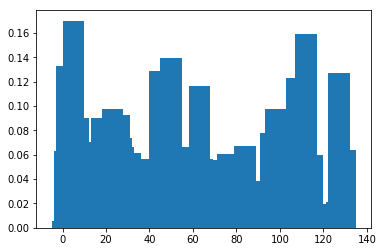

In [57]:
plt.bar(range(131),test_rmse,10)

<Container object of 131 artists>

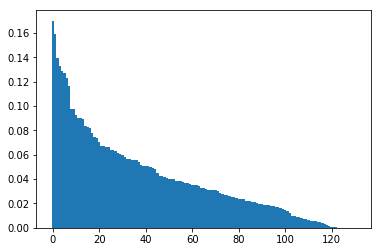

In [56]:
plt.bar(range(131),sorted(test_rmse,reverse=True),1)

In [63]:
import numpy as np
#bins = [0, 0.8]
#hist, bin_edges = np.histogram(test_rmse, bins=bins)
hist, bin_edges = np.histogram(test_rmse, bins=30)
print (hist)
print (bin_edges)
df_binedges = pd.DataFrame()

#create dataframe with bin values
for i in range(len(hist)):
    df_binedges.at[i,'binedge_1'] = float(bin_edges[i])
    df_binedges.at[i,'binedge_2'] = float(bin_edges[i+1])
    df_binedges.at[i,'count'] = hist[i]

df_binedges

[17 11  6 14 11  8 11  8  4  8  5  7  2  2  3  3  1  2  0  0  1  1  2  1
  1  0  0  0  1  1]
[1.73160802e-05 5.69074372e-03 1.13641714e-02 1.70375990e-02
 2.27110266e-02 2.83844543e-02 3.40578819e-02 3.97313095e-02
 4.54047372e-02 5.10781648e-02 5.67515925e-02 6.24250201e-02
 6.80984477e-02 7.37718754e-02 7.94453030e-02 8.51187306e-02
 9.07921583e-02 9.64655859e-02 1.02139014e-01 1.07812441e-01
 1.13485869e-01 1.19159296e-01 1.24832724e-01 1.30506152e-01
 1.36179579e-01 1.41853007e-01 1.47526435e-01 1.53199862e-01
 1.58873290e-01 1.64546718e-01 1.70220145e-01]


,binedge_1,binedge_2,count
0,0.000017,0.005691,17.0
1,0.005691,0.011364,11.0
2,0.011364,0.017038,6.0
3,0.017038,0.022711,14.0
4,0.022711,0.028384,11.0
5,0.028384,0.034058,8.0
6,0.034058,0.039731,11.0
7,0.039731,0.045405,8.0
8,0.045405,0.051078,4.0
9,0.051078,0.056752,8.0
